In [75]:
import yfinance as yf
import numpy as np
import pandas as pd
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import time

symbol = 'TSLA'
start_date = '2022-01-01'
end_date = '2023-06-09'


def get_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data.index = pd.to_datetime(data.index, unit='1d')
    return data

stock_data = get_stock_data(symbol, start_date, end_date)
prices = stock_data['Close']
prices.tail()

[*********************100%***********************]  1 of 1 completed


Date
2023-06-02    213.970001
2023-06-05    217.610001
2023-06-06    221.309998
2023-06-07    224.570007
2023-06-08    234.860001
Name: Close, dtype: float64

In [76]:
# claculate standard deviation
std_dev = np.std(prices)
mean_price = np.mean(prices)

print(std_dev)
print(mean_price)

63.88354732778326
237.2266757965088


In [77]:
max_grid_count = 6
grid_count_up = 0
grid_count_down = 0
percentage_change = 0.05

grid_levels_up = []
price_up = stock_data.iloc[-1]['Close']
grid_count_up = 0
while price_up < (price_up + std_dev) and grid_count_up < max_grid_count:
    grid_levels_up.append(round(price_up, 2))
    price_up += round((price_up * percentage_change), 2)
    grid_count_up += 1


grid_levels_down = []
price_down = stock_data.iloc[-1]['Close']
grid_count_down = 0
while price_down > (price_down - std_dev) and grid_count_down < max_grid_count:
    grid_levels_down.append(round(price_down,2))
    price_down -= round((price_down * percentage_change),2)
    grid_count_down += 1

print("grid levels up:")
for level in grid_levels_up:
    print(level)

print("grid levels down:")
for level in grid_levels_down:
    print(level)

grid levels up:
234.86
246.6
258.93
271.88
285.47
299.74
grid levels down:
234.86
223.12
211.96
201.36
191.29
181.73


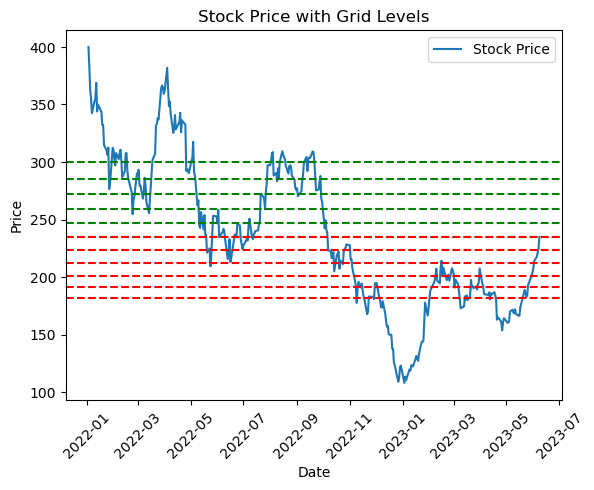

In [79]:
plt.plot(stock_data['Close'], label='Stock Price')

for level in grid_levels_up:
    plt.axhline(y=level, color='g', linestyle='--')
for level in grid_levels_down:
    plt.axhline(y=level, color='r', linestyle='--')
    
plt.title('Stock Price with Grid Levels')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [80]:
#Backtest

initial_cash = 1000000
cash = initial_cash
stock_qty = 0
stock_value = 0
quantity = 100

# Set the start date for backtesting
start_date = '2022-05-01'  # Replace with your desired start date

# Find the index of the start date in the stock data
start_index = stock_data.index.get_loc(pd.to_datetime(start_date, format='%Y-%m-%d'))

# Backtest starting from the specified date
for i in range(start_index, len(stock_data)):
    # get current date and stock price.
    date = stock_data.index[i]
    price = stock_data.iloc[i]['Close']

    # check if triggar the buy condition
    if price == grid_levels_down[grid_count_down] and cash >= price * quantity:
        stock_qty += quantity
        stock_value += price * quantity
        cash -= price * quantity
        grid_count_down += 1
        print(f"{date} - buy {quantity} shares at {price}")

    # check if triggar the sell condition
    if price == grid_levels_up[grid_count_up] and stock_qty >= quantity:
        stock_qty -= quantity
        stock_value -= price * quantity
        cash += price * quantity
        grid_count_up += 1
        print(f"{date} - sell {quantity} shares at {price}")

# calculate the backtest result
portfolio_value = cash + stock_value
pnl = portfolio_value - initial_cash
return_rate = pnl / initial_cash * 100

print("Backtest Result：")
print(f"Initial Cash：{initial_cash}")
print(f"Final Value：{portfolio_value}")
print(f"Profits：{pnl}")
print(f"Return Rate：{return_rate}%")

KeyError: Timestamp('2022-05-01 00:00:00')

In [20]:
# Create a connection to the API 
load_dotenv("Alpacakey.env")
API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"
api = tradeapi.REST(API_KEY, API_SECRET, ALPACA_API_BASE_URL, api_version="v2")


In [21]:
grid_count_up = 0
grid_count_down = 0

while True:
    try:
        current_price = api.get_last_trade(symbol).price
        
        print(current_price)

        if current_price > (mean_price + std_dev) or current_price < (mean_price - std_dev):
            print('Exceed trading price limit, stop trading')
            break

        if current_price < grid_levels_down[grid_count_down] and grid_count_down <= max_grid_count:
            # Calculate the buy price
            target_price = current_price - (current_price * 0.05)

            # Submit order
            api.submit_order(
                symbol=symbol,
                qty=100,
                side='buy',
                type='limit',
                time_in_force='gtc',
                limit_price=target_price
            )
            print('At', target_price, 'price to buy 100 shares')

            # 添加新的下跌网格水平线
            # grid_levels_down.append(target_price)
            grid_count_down += 1

        elif current_price > grid_levels_up[grid_count_down]and grid_count_up <= max_grid_count:
            # Calculate the sell price
            target_price = current_price + (current_price * 0.05)

            # Submit order
            api.submit_order(
                symbol=symbol,
                qty=100,
                side='sell',
                type='limit',
                time_in_force='gtc',
                limit_price=target_price
            )
            print('At', target_price, 'price to sell 100 shares')

            # 添加新的上涨网格水平线
            # grid_levels_up.append(target_price)
            grid_count_up += 1

        time.sleep(10)

    except Exception as e:
        print('Error:', str(e))
        time.sleep(10)



Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'REST' object has no attribute 'get_last_trade'
Error: 'RE

KeyboardInterrupt: 